# Dane panelowe - czyli wiele szeregów czasowych

Zbiór danych: https://www.kaggle.com/datasets/hamidrezabakhtaki/fmcg-export-sale

## Preprocessing

In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score

In [2]:
# puść ten kod, 
# jeżeli wywołujesz plik  w folderze rozwiąznaia, 
# a ramka danych znajduje się w folderze data
import os 
os.chdir('../')

In [3]:
# wczytanie danych
df = pd.read_csv("data/ExportSales.csv")

In [4]:
# nagłówek
df.head()

,ID,Date,Category,Invoice Number,Product Code,Customer Code,Destenation,QTY,Total Price
0,2529604,2019-04-28,Category5,267,30011006,612,IRQ,750,3334.8225
1,2529605,2019-04-29,Category5,302,30011006,514,BHR,400,3032.8240
2,2529606,2019-05-13,Category5,507,30011006,513,BHR,100,749.9520
3,2529607,2019-06-01,Category5,795,30011006,5,SYC,100,556.8170
4,2529608,2019-07-03,Category5,1184,30011006,560,AFG,20,39.4460


In [5]:
# Agregacja danych
df_agg = df[['Date','Category','Product Code', 'QTY', 'Total Price']].groupby(['Date','Category','Product Code']).sum().reset_index()
df_agg.head()

,Date,Category,Product Code,QTY,Total Price
0,2019-04-07,Category4,30001095,70,1202.8310
1,2019-04-07,Category4,30001096,40,687.3320
2,2019-04-07,Category4,30001097,30,515.4990
3,2019-04-07,Category4,30001135,10,105.5546
4,2019-04-07,Category6,30002072,50,1423.7590


In [7]:
# Liczba wystąpień w zbiorze
products = df['Product Code'].value_counts().sort_values(ascending=False)[:10]

In [8]:
# 10 największych produktów
products

Product Code
30006003    463
30006004    344
30006002    328
30009011    242
30006023    213
30009007    169
30011006    166
30009016    139
30009017    127
30001311    106
Name: count, dtype: int64

In [9]:
# Przefiltrowana ramka
df_to_analysis = df_agg.loc[df_agg['Product Code'].isin(products.index),:]
df_to_analysis.head()

,Date,Category,Product Code,QTY,Total Price
18,2019-04-28,Category5,30011006,750,3334.82250
34,2019-04-29,Category5,30011006,400,3032.82400
60,2019-05-13,Category5,30011006,100,749.95200
63,2019-05-13,Category8,30009007,20,102.67200
71,2019-05-20,Category8,30009007,23,78.20069


In [10]:
# Konwersja daty
df_to_analysis.loc[:,'Date'] = pd.to_datetime(df_to_analysis['Date'])

In [11]:
# Zmiana indeksu
df_to_analysis = df_to_analysis.set_index('Date')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [12]:
# Resample do danych miesiecznych
df_resampled = df_to_analysis[['Product Code','Category','QTY','Total Price']].groupby(['Category','Product Code']).resample('ME')[['QTY','Total Price']].sum().reset_index().fillna(0)

In [13]:
df_resampled.head()

,Category,Product Code,Date,QTY,Total Price
0,Category4,30001311,2020-07-31,800,17351.20
1,Category4,30001311,2020-08-31,0,0.00
2,Category4,30001311,2020-09-30,1070,27765.43
3,Category4,30001311,2020-10-31,1120,36115.80
4,Category4,30001311,2020-11-30,950,26093.65


In [15]:
df_resampled

,Category,Product Code,Date,QTY,Total Price,month,quarter
0,Category4,30001311,2020-07-31,800,17351.20000,7,3
1,Category4,30001311,2020-08-31,0,0.00000,8,3
2,Category4,30001311,2020-09-30,1070,27765.43000,9,3
3,Category4,30001311,2020-10-31,1120,36115.80000,10,4
4,Category4,30001311,2020-11-30,950,26093.65000,11,4
...,...,...,...,...,...,...,...
337,Category8,30009017,2022-04-30,1300,10181.70000,4,2
338,Category8,30009017,2022-05-31,1375,11780.14000,5,2
339,Category8,30009017,2022-06-30,3325,29401.69375,6,2
340,Category8,30009017,2022-07-31,1400,13162.93125,7,3


In [14]:
# miesiac i kwartal z daty
df_resampled['month'] = df_resampled['Date'].dt.month
df_resampled['quarter'] = df_resampled['Date'].dt.quarter

In [17]:
# Stworzenie y_diff
df_resampled = df_resampled.sort_values(by=['Product Code', 'Date'])
df_resampled['y_diff'] = df_resampled.groupby('Product Code')['QTY'].diff()
df_resampled['QTY_lag'] = df_resampled.groupby('Product Code')['QTY'].shift(1)
df_resampled.dropna(inplace=True)

In [18]:
# zmienna - cena jednostkowa
df_resampled['price'] = df_resampled['Total Price'] / df_resampled['QTY']

In [20]:
# Encoding kategorii
df_resampled['category_encoded'] = OrdinalEncoder().fit_transform(df_resampled[['Category']])

In [21]:
# graniczna data
date = df_resampled['Date'].quantile(0.7)
date

Timestamp('2021-11-30 00:00:00')

In [22]:
# przypisanie model setu jako kolumna
df_resampled['model_set'] = 'train'
df_resampled.loc[df_resampled['Date']>date,'model_set'] = 'test'

In [23]:
# zapisanie danych 
df_resampled.to_csv('data/panel_data.csv')

In [24]:
# train/test
train = df_resampled[df_resampled['model_set']=='train']
test = df_resampled[df_resampled['model_set']=='test']

In [25]:
# zmienne x
x_names = ['month', 'quarter','category_encoded','QTY_lag','price']

In [26]:
#train x/y

train_x = train[x_names]
test_x = test[x_names]

In [27]:
# Model
model = RandomForestRegressor(max_depth=20, min_samples_leaf=10, n_estimators=200).fit(train_x, train['y_diff'])

In [28]:
# Predict
df_resampled['predict'] = model.predict(df_resampled[model.feature_names_in_])

<Axes: xlabel='Date'>

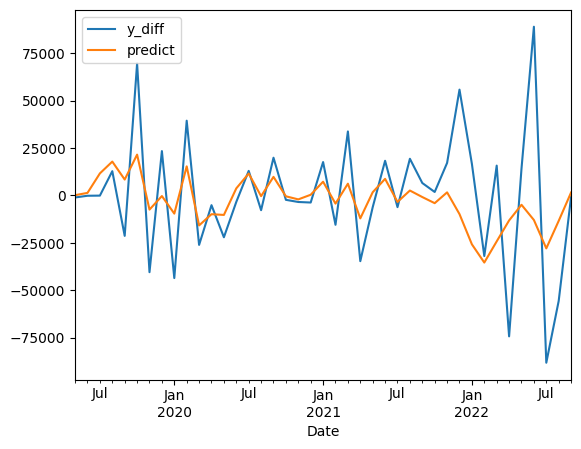

In [29]:
# Sprawdzenie całego szeregu
df_resampled[['Date','y_diff','predict']].groupby('Date').sum().plot()

In [30]:
df_resampled['Product Code'].unique()

array([30001311, 30006002, 30006003, 30006004, 30006023, 30009007,
       30009011, 30009016, 30009017, 30011006])

<Axes: xlabel='Date'>

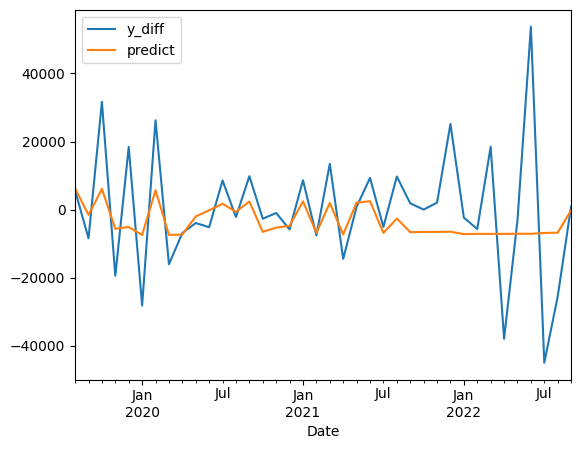

In [32]:
df_resampled.loc[df_resampled['Product Code'] ==30006003 ,['Date','y_diff','predict']].groupby('Date').sum().plot()

In [ ]:
# r2
r2_score(df_resampled.loc[df_resampled['model_set']=='test','predict'],test['y_diff'])

-12.356427534275202

In [35]:
# predict
df_resampled.tail()

,Category,Product Code,Date,QTY,Total Price,month,quarter,y_diff,QTY_lag,price,category_encoded,model_set,predict
59,Category5,30011006,2022-04-30,1300,14032.6200,4,2,-4992.0,6292.0,10.794323,1.0,test,729.660057
60,Category5,30011006,2022-05-31,4900,50973.4650,5,2,3600.0,1300.0,10.402748,1.0,test,355.789225
61,Category5,30011006,2022-06-30,575,7763.3875,6,2,-4325.0,4900.0,13.501543,1.0,test,-540.589047
62,Category5,30011006,2022-07-31,675,8840.6875,7,3,100.0,575.0,13.097315,1.0,test,768.906182
63,Category5,30011006,2022-08-31,800,10582.4675,8,3,125.0,675.0,13.228084,1.0,test,838.060247


In [36]:
model.feature_names_in_

array(['month', 'quarter', 'category_encoded', 'QTY_lag', 'price'],
      dtype=object)

In [37]:
# Predykcja
model.predict(pd.DataFrame([9,3,1,800,13.23]).transpose())

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([809.96654277])